In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 코랩에서 실행되는 노트북인가요?
IS_COLAB = "google.colab" in sys.modules

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 CNN은 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 골통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

감지된 GPU가 없습니다. GPU가 없으면 CNN은 매우 느릴 수 있습니다.


In [3]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

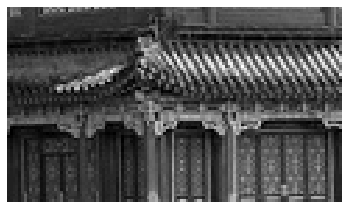

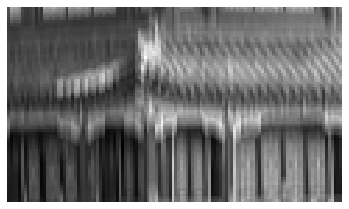

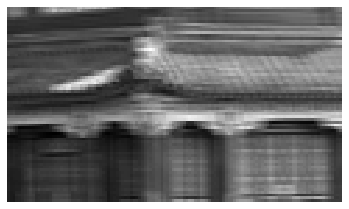

In [15]:
import numpy as np
from sklearn.datasets import load_sample_image

# 샘플 이미지를 로드합니다.
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

def crop(images):
    return images[150:220, 130:250]


# 크롭한 원본
plot_image(crop(images[0, :, :, 0]))
plt.show()

# 크롭한 수직선필터적용 / 수평선 필터 적용
for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

In [25]:
np.random.seed(42)
tf.random.set_seed(42)

# 2D 합성곱층 생성
conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)
conv_outputs = conv(images)

print('배치크기(이미지개수), 높이, 너비, 채널(이미지별 특성맵개수)')
print(conv_outputs.shape)

배치크기(이미지개수), 높이, 너비, 채널(이미지별 특성맵개수)
(2, 427, 640, 2)


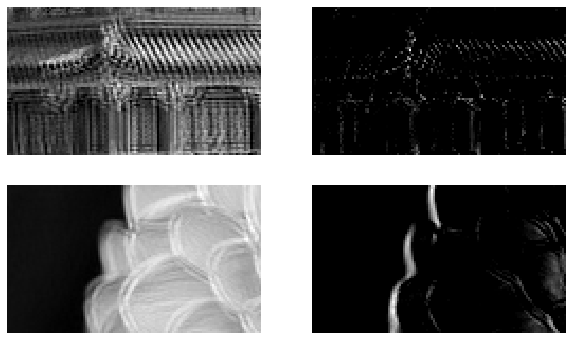

In [27]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()
# 처음은 랜덤 결과, 두번째는 edge 추출
# 알아서 필터와 편향을 학습하기 때문에 지정할 필요가 없으나 필터에 수동으로 지정할수있다.
# conv.set_weights([filters, np.zeros(2)])
# 앞에서 한 것처럼 수직, 수평선을 부각시키는 특성맵 탄생

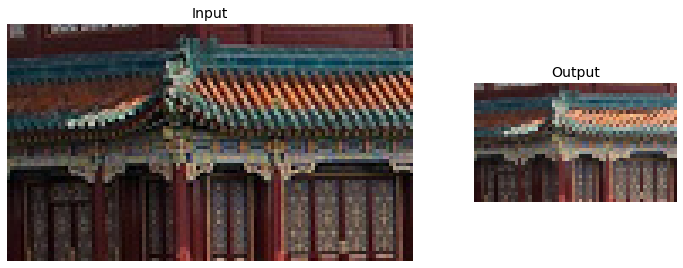

In [31]:
# 풀링층 - 최대풀링
max_pool = keras.layers.MaxPool2D(pool_size=2)

cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # 첫 번째 이미지 출력 그리기
ax2.axis("off")
# save_fig("china_max_pooling")
plt.show()

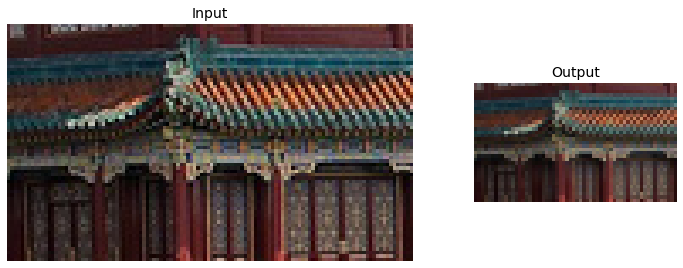

In [30]:
# 풀링층 - 평균풀링
avg_pool = keras.layers.AvgPool2D(pool_size=2)

cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = avg_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # 첫 번째 이미지 그리기
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # 첫 번째 이미지 출력 그리기
ax2.axis("off")

# save_fig("china_max_pooling")
plt.show()

In [32]:
# 깊이방향 풀링 - 어떠한 불변성도 학습할 수 있다.다양한 왜곡이 동일한 출력을 만듬
# 케라스가 제공하지 않지만 텐서플로 API를 활용하여 구현
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              # 배치 높이 너비 차원을 따라 커널크기와 스트라이드가 1이란 뜻
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)
    
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # 아직 GPU 커널이 없습니다.
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

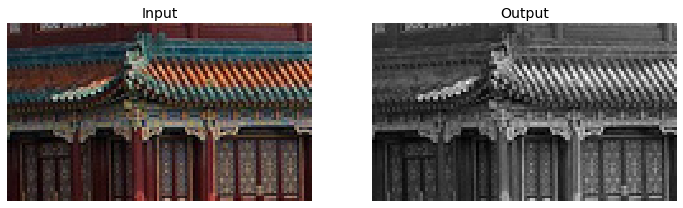

In [33]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # 첫 번째 이미지 그리기
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # 첫 번째 이미지 출력 그리기
plt.axis("off")
plt.show()

In [34]:
## 전역 평균 풀링
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

In [36]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

In [37]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [38]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [39]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # 새로운 이미지처럼 사용합니다
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 181s 105ms/step - loss: 0.7101 - accuracy: 0.7528 - val_loss: 0.3759 - val_accuracy: 0.8654
Epoch 2/10
1719/1719 [==============================] - 178s 104ms/step - loss: 0.4265 - accuracy: 0.8568 - val_loss: 0.3401 - val_accuracy: 0.8752
Epoch 3/10
1719/1719 [==============================] - 178s 104ms/step - loss: 0.3652 - accuracy: 0.8772 - val_loss: 0.3319 - val_accuracy: 0.8844
Epoch 4/10
1719/1719 [==============================] - 178s 104ms/step - loss: 0.3383 - accuracy: 0.8865 - val_loss: 0.3026 - val_accuracy: 0.8942
Epoch 5/10
1719/1719 [==============================] - 186s 108ms/step - loss: 0.3114 - accuracy: 0.8934 - val_loss: 0.3001 - val_accuracy: 0.8962
Epoch 6/10
1719/1719 [==============================] - 179s 104ms/step - loss: 0.2977 - accuracy: 0.8984 - val_loss: 0.2925 - val_accuracy: 0.8968
Epoch 7/10
1719/1719 [==============================] - 186s 108ms/step - loss: 0.2792 - accuracy: 0.9045 - val_